# Firing distribution of hidden neurons

## 概要
- マウスの視覚野のニューロンが画像を符号化する際の次元を解析したところ, `n`番目の主成分の分散が 1/n にスケーリングされるというべき乗則に従っていることが発見された[1].
    - 冪指数が小さいと, モデルのロバスト性が下がる. (入力のわずかな変化で)
    - 冪指数の大小と, 与える刺激の複雑さ(与えた画像の複雑さ)には関係性がある. シンプルな画像ほど冪指数が大きい.
- 人工ニューラルネットワークでは, 冪指数 -1 の現象はうまく再現できなかった(M1後藤さんの研究)
- 確率的なモデルで調査 -> 制限ボルツマンマシン(RBM)で実験
- RBM と類似の隠れ層コーディングを行う Autoencoder でも実験を行う

## 実験
- 冪指数を調査
    - 各 iteration 毎で ----- 学習の前後の変化を調べる
    -  Simple(e.g. MNIST) or Complex(Fashon-MNIST とか) ----- 学習させる刺激の複雑さと冪指数の関係性を調べる
        - 極端な例を学習させてもいいかも
    - 様々なモデルで ----- モデルから冪指数分布の法則性を探る・-1 の指数を持つ分布がないか調べる
        - RBM, Deep BM, Autoencoder, NN, CNN, etc,
        - with various parameters

## 課題
- ~~Autoencoder がちゃんと動いていないように見える, 実装を確認してほしい~~ epoch をうんと増やしたら動いた
- 教師なしモデルなので, accuracy の定義を検討中
    - ボルツマンマシンの性能を評価する指標があるのであればそれを用いたい (KL-Divergence? VGGに判定させる)
- GPU で動くモデルに書き換える


## Reference
- [1] High-dimensional geometry of 
population responses in visual cortex, Carsen, S. et al., 2019, https://www.nature.com/articles/s41586-019-1346-5
- [2] On 1/n neural representation and robustness, Josue et al., 2020, https://arxiv.org/abs/2012.04729
- [2] https://github.com/bacnguyencong/rbm-pytorch

# Experiment scripts

In [34]:
import matplotlib.pyplot as plt

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torchvision.utils import make_grid

## RBM による冪指数の調査
### 学習前後での変化

In [35]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = "cpu"
device

'cpu'

In [36]:
batch_size = 128 # batch size
n_epochs = 10 # number of epochs
lr = 0.01 # learning rate
n_hid = 100 # number of neurons in the hidden layer
n_vis = 28*28 # input size
k = 3 # The number of Gibbs sampling

In [37]:
class RBM(nn.Module):
    def __init__(self, n_vis, n_hid, k=1, *args, **kwargs):
        super(RBM, self).__init__(*args, **kwargs)
        self.v = nn.Parameter(torch.randn(1, n_vis))
        self.h = nn.Parameter(torch.randn(1, n_hid))
        self.W = nn.Parameter(torch.randn(n_hid, n_vis))
        self.k = k

    def visible_to_hidden(self, v): # TODO GPU で動かしたいので nn.Module を使って書き換える
        p = torch.sigmoid(F.linear(v, self.W, self.h))
        return p.bernoulli()

    def hidden_to_visible(self, h):
        p = torch.sigmoid(F.linear(h, self.W.t(), self.v))
        return p.bernoulli()

    def free_energy(self, v):
        v_term = torch.matmul(v, self.v.t())
        w_x_h = F.linear(v, self.W, self.h)
        h_term = torch.sum(F.softplus(w_x_h), dim=1)
        return torch.mean(-h_term - v_term)

    def forward(self, v):
        h = self.visible_to_hidden(v)
        for _ in range(self.k):
            v_gibb = self.hidden_to_visible(h)
            h = self.visible_to_hidden(v_gibb)
        return v_gibb

In [38]:
# create a Restricted Boltzmann Machine
model = RBM(n_vis=n_vis, n_hid=n_hid, k=k).cpu() # TODO to(device)

In [39]:
train_datasets = datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=transforms.Compose([transforms.ToTensor()])
    )
train_loader = torch.utils.data.DataLoader(
    dataset=train_datasets,
    batch_size=batch_size,
    shuffle=True,
)
test_datasets = datasets.MNIST(
    root="./data",
    train=False,
    download=True,
    transform=transforms.Compose([transforms.ToTensor()])
)
test_loader = torch.utils.data.DataLoader(
    dataset=test_datasets,
    batch_size=batch_size,
    shuffle=True
)

In [40]:
def neuron_fireing_vis(n_dataset, n_hid):
    """
    全データに対する隠れ層のニューロン発火行列を取得
    """
    vv1 = np.zeros((len(train_datasets), n_hid))

    for idx, (x, y) in enumerate(train_loader):
        x = x.view(-1, n_vis)
        vv1[idx*batch_size:(idx+1)*batch_size, :] = model.visible_to_hidden(x).detach().cpu().numpy() # [batch_size, n_hid]
    return vv1

In [41]:
from tqdm import tqdm

loss_ = []
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
model.train()


neuron_fireings = []
neuron_fireings.append(neuron_fireing_vis(n_dataset=len(train_datasets), n_hid=n_hid))
with tqdm(range(n_epochs)) as t:
    for epoch in t:
        for (data, target) in train_loader:
            v = data.view(-1, n_vis)
            v_gibbs = model(v)
            loss = model.free_energy(v) - model.free_energy(v_gibbs)
            loss_.append(loss.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        t.set_description(f"loss={loss.item():.2}")
        neuron_fireings.append(neuron_fireing_vis(n_dataset=len(train_datasets), n_hid=n_hid))


loss=1.2e+01: 100%|███████████████████| 10/10 [02:24<00:00, 14.50s/it]


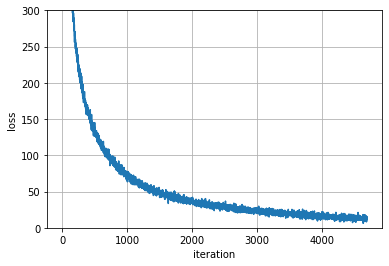

In [42]:
import matplotlib.pyplot as plt

plt.plot(loss_)
plt.xlabel('iteration')
plt.ylabel('loss')
plt.ylim(0, 300)
plt.grid()

テスト画像を想起させてみる
- インプット画像:

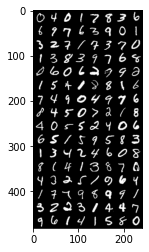

In [43]:
from torchvision.utils import make_grid

images = next(iter(test_loader))[0]
v = images.view(-1, 784)
v_gibbs = model(images.view(-1, 784))
npimg = np.transpose(make_grid(v.view(batch_size, 1, 28, 28).data).numpy(), (1, 2, 0))
plt.imshow(npimg, cmap="gray")

- 想起画像

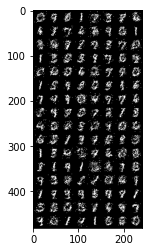

In [44]:
npimg = np.transpose(make_grid(v_gibbs.view(batch_size, 1, 28, 28).data).numpy(), (1, 2, 0))
plt.imshow(npimg, cmap="gray")

In [45]:
vv1 = neuron_fireing_vis(n_dataset=len(train_datasets), n_hid=n_hid)
vv1.shape

(60000, 100)

発火分布の視覚化

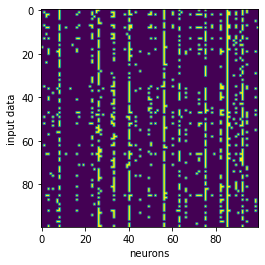

In [46]:
plt.xlabel("Neurons")
plt.ylabel("Input data")
plt.imshow(vv1[:100, :])


In [47]:
import sklearn
from sklearn.decomposition import PCA

vv1 = sklearn.preprocessing.scale(vv1)

In [ ]:
pca = PCA()
pca.fit(vv1)
print(pca.explained_variance_)

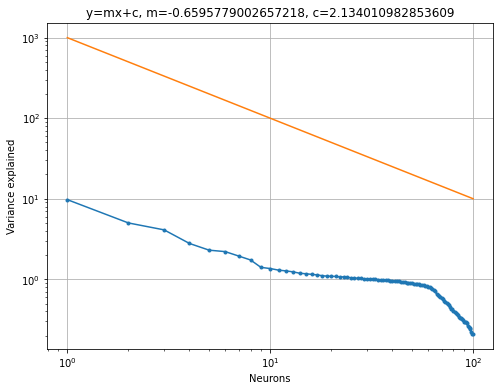

In [49]:
fig, ax = plt.subplots(figsize=(8, 6))
xx = np.arange(len(pca.explained_variance_)) + 1
ax.plot(xx, pca.explained_variance_, '.-')
ax.plot(xx, 1000 * xx ** (-1.0))

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Neurons')
ax.set_ylabel('Variance explained')
xx = np.log(xx)
yy = np.log(pca.explained_variance_)
m, c = np.linalg.lstsq(np.vstack([xx, np.ones(len(xx))]).T, yy, rcond=None)[0]
ax.set_title(f'y=mx+c, m={m}, c={c}')
ax.grid()

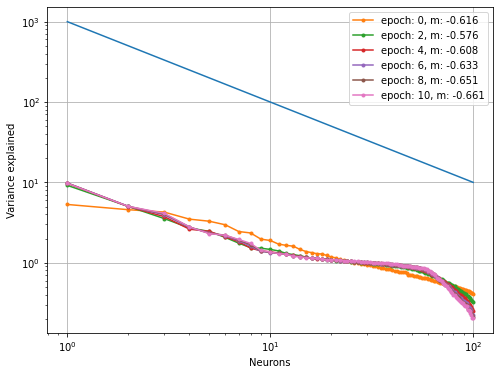

In [50]:
fig, ax = plt.subplots(figsize=(8, 6))
xx = np.arange(len(pca.explained_variance_)) + 1
log_xx = np.log(xx)
ax.plot(xx, 1000 * xx ** (-1.0))
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Neurons')
ax.set_ylabel('Variance explained')
for i, vv in enumerate(neuron_fireings):
    if i % 2 == 1:
        continue
    vv = sklearn.preprocessing.scale(vv)
    pca = PCA()
    pca.fit(vv)
    yy = pca.explained_variance_
    log_yy = np.log(yy)
    m, c = np.linalg.lstsq(np.vstack([log_xx, np.ones(len(log_xx))]).T, log_yy, rcond=None)[0]
    ax.plot(xx, yy, '.-', label=f"epoch: {i}, m: {m:.3}")
plt.legend()
ax.grid()

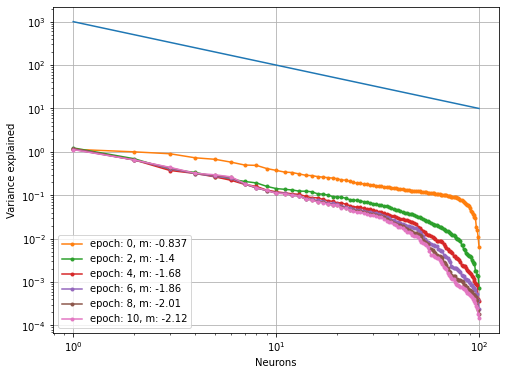

In [51]:
fig, ax = plt.subplots(figsize=(8, 6))
xx = np.arange(len(pca.explained_variance_)) + 1
log_xx = np.log(xx)
ax.plot(xx, 1000 * xx ** (-1.0))
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Neurons')
ax.set_ylabel('Variance explained')
for i, vv in enumerate(neuron_fireings):
    if i % 2 == 1:
        continue
    # vv = sklearn.preprocessing.scale(vv)
    pca = PCA()
    pca.fit(vv)
    yy = pca.explained_variance_
    log_yy = np.log(yy)
    m, c = np.linalg.lstsq(np.vstack([log_xx, np.ones(len(log_xx))]).T, log_yy, rcond=None)[0]
    ax.plot(xx, yy, '.-', label=f"epoch: {i}, m: {m:.3}")
plt.legend()
ax.grid()

### 隠れ層数の変化

In [52]:
def training(model, n_epochs, lr):
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    model.train()
    loss_ = []

    for epoch in range(n_epochs):
        for (data, target) in train_loader:
            v = data.view(-1, n_vis)
            v_gibbs = model(v)
            loss = model.free_energy(v) - model.free_energy(v_gibbs)
            loss_.append(loss.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    return model, loss.item()


In [53]:

neuron_fireings = []
for n_hid in tqdm([2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]):
    model = RBM(n_vis=n_vis, n_hid=n_hid, k=k).cpu()
    model, loss = training(model, n_epochs=n_epochs, lr=lr)
    neuron_fireings.append((n_hid, neuron_fireing_vis(n_dataset=len(train_datasets), n_hid=n_hid)))
    


100%|████████████████████████████████| 10/10 [16:47<00:00, 100.73s/it]


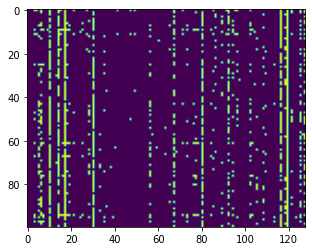

In [56]:
n_hid, vv = neuron_fireings[6]
plt.imshow(vv[:100, :])

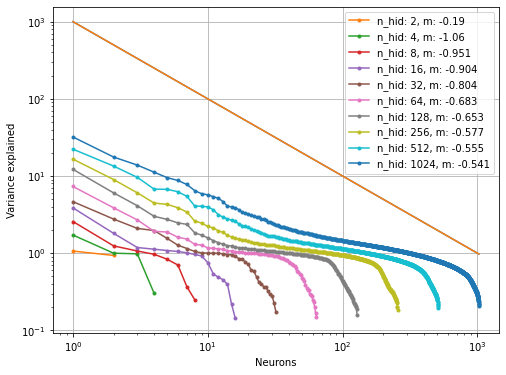

In [64]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(xx, 1000 * xx ** (-1.0))
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Neurons')
ax.set_ylabel('Variance explained')
for n_hid, vv in neuron_fireings:
    vv = sklearn.preprocessing.scale(vv)
    pca = PCA()
    pca.fit(vv)
    yy = pca.explained_variance_
    xx = np.arange(len(pca.explained_variance_)) + 1
    log_xx = np.log(xx)
    log_yy = np.log(yy)
    m, c = np.linalg.lstsq(np.vstack([log_xx, np.ones(len(log_xx))]).T, log_yy, rcond=None)[0]
    ax.plot(xx, yy, '.-', label=f"n_hid: {n_hid}, m: {m:.3}")
ax.plot(xx, 1000 * xx ** (-1.0))
plt.legend()
ax.grid()

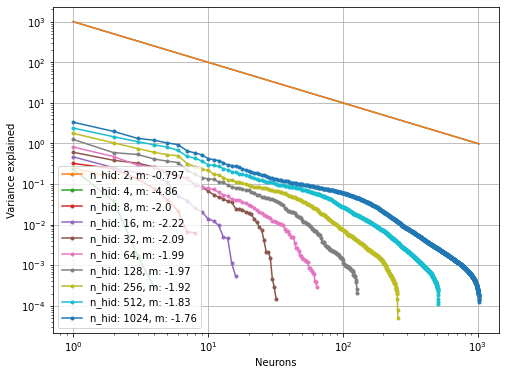

In [65]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(xx, 1000 * xx ** (-1.0))
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Neurons')
ax.set_ylabel('Variance explained')
for n_hid, vv in neuron_fireings:
    # vv = sklearn.preprocessing.scale(vv)
    pca = PCA()
    pca.fit(vv)
    yy = pca.explained_variance_
    xx = np.arange(len(pca.explained_variance_)) + 1
    log_xx = np.log(xx)
    log_yy = np.log(yy)
    m, c = np.linalg.lstsq(np.vstack([log_xx, np.ones(len(log_xx))]).T, log_yy, rcond=None)[0]
    ax.plot(xx, yy, '.-', label=f"n_hid: {n_hid}, m: {m:.3}")
ax.plot(xx, 1000 * xx ** (-1.0))
plt.legend()
ax.grid()